In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import librosa
# import seaborn as sns
from sklearn.linear_model import SGDClassifier

In [3]:
def half_rectify(n):
    return np.fmax(n, np.zeros_like(n))

In [4]:
def spectral_flux(spec):
    """
    Computes the spectral flux of a spectrogram
    :param spec: a 2-D array of floats
    :return: a numpy array
    """
    return np.sum(np.square(half_rectify(np.absolute(spec[:, 1:]) -
                                         np.absolute(spec[:, :-1]))), 0)

In [5]:
def make_feature_set(spec, spec_dt, annotation_path, w_length):
    """
    Generates features and labels from spectrogram.
    :param spec: NxM numpy array
    :param spec_dt: float
    :param annotation_path: String
    :param w_length: int
    :return: features, labels
    """
    if annotation_path is not None:
        df = pd.read_csv(annotation_path, header=None, 
            names=['onsets', 'offsets', 'label'], delimiter='\t')
        onsets = np.asarray(df['onsets'])
        offsets = np.asarray(df['offsets'])

    num_features = spec.shape[1]-w_length+1

    # Generate features
    features = [[]] * num_features
    for i in xrange(num_features):
    	features[i] = np.ravel(spec[:, i:i+w_length])

    # Generate labels
    if annotation_path is not None:
        labels = np.zeros(num_features)
#         for on, off in zip(onsets, offsets):
        for on in onsets:
#             center = (on+off)/2
#             start = int(np.round((center-0.100)/spec_dt))
#             finish = int(np.round((center+0.100)/spec_dt))
            start = int(np.round((on-0.100)/spec_dt))
            finish = int(np.round((on+0.100)/spec_dt))
            labels[start:finish+1] = 1
        return np.asarray(features), labels

    return np.asarray(features)

In [6]:
# Audio params

filename = "../audio/SBI-1_20090915_234016.wav"
annotation_path = "../annotations/SBI-1_20090915_HAND_LOW_IDaek_EDITED_with_HIGH.txt"
model_path = "../features/SBI_coefs_41.npy"

# Load audio and compute spectrogram
sr = 24000
n_fft = 256 # =win_length
win_length = n_fft
hop_length = 128.0
hop_size = hop_length/sr # in seconds
win_size = win_length/sr # in seconds
spec_dt = hop_length/sr # in seconds

# Define length of coefficient window
w_length = 5

In [7]:
# Training params

# Iterate through signal by large blocks (constrained by RAM)
num_hops_per_block = 10000
duration = 3000          #seconds
block_size = hop_size*num_hops_per_block
block_len = num_hops_per_block-w_length+2

# duration = num_hops_per_block*hop_size+win_size     # in secs

In [8]:
####################################################
# Train model
model = SGDClassifier(loss='log', penalty='elasticnet', verbose=2, warm_start=True, class_weight='auto')
block_i = 0
done = False

while not done:
    print "Processing next block... i={} ".format(block_i) + str(time.clock())
    offset = block_i*block_len
    y, _ = librosa.load(filename, offset=offset, duration=block_size, sr=sr)
    if len(y) < block_size*sr or (duration is not None and offset > duration):
        print "last one!"
        # BAD!!! Throwing out last bit of data
        break
        done = True
#     D = np.log10(np.abs(librosa.core.stft(y, n_fft=n_fft, hop_length=hop_length)))
    D = (np.abs(librosa.core.stft(y, n_fft=n_fft, hop_length=hop_length)))

    (features, labels) = make_feature_set(D, spec_dt, annotation_path,
            w_length)

#     print features.shape, labels.shape
    actual_features = np.square(half_rectify(np.absolute(features[1:, :]) -
                                     np.absolute(features[:-1, :])))

    print actual_features.shape
    break
    actual_labels = labels[1:]
    
    # MAKE SURE I'M NOT THROWING ANYTHING AWAY
#     print actual_features.shape
    
    model.partial_fit(actual_features,actual_labels,classes=[0,1])

    block_i += 1
    


Processing next block... i=0 2.552871
(9996, 645)


(129, 5)


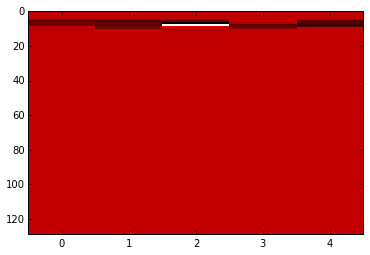

In [30]:
coefs2 = model.coef_.reshape((n_fft/2 + 1, w_length))
coefs = model.coef_
model.coef_.shape
# np.save(model_path, coefs)
# print np.nonzero(actual_labels)
# print len(actual_labels)
# print np.sum(coefs)
print coefs2.shape
plt.imshow((coefs2), interpolation='nearest', aspect='auto', cmap='hot')

In [39]:
np.argmax(coefs2[:,2])

8

In [31]:
####################################################
# Evaluate model
test_path = '../audio/NSDNS_20110902_192900.wav'
detection_curve_path = '../detection_functions/NSDNS_SF_43.npy'

# coefs = np.load(model_path)
# c = coefs.reshape(645,1)
block_i = 0
duration = None          #seconds
done = False
detection_curve = np.zeros((1,0))

block_len = num_hops_per_block-w_length+2

while not done:
    print "Testing next block... i={} ".format(block_i) + str(time.clock())
    offset = block_i*block_len
    y, _ = librosa.load(test_path, offset=offset, duration=block_size, sr=sr)
    if len(y) < block_size*sr or (duration is not None and offset > duration):
        print "last one!"
        # BAD!!! Throwing out last bit of data
        break
        done = True
    D = np.log(np.abs(librosa.core.stft(y, n_fft=n_fft, hop_length=hop_length)))

    features = np.asarray(make_feature_set(D, spec_dt, annotation_path=None, 
        w_length=w_length))

    actual_features = np.square(half_rectify(np.absolute(features[1:, :]) -
                                     np.absolute(features[:-1, :])))
    
#     features = features.T

#     print features.shape
    
    # Template detector
    # detection_curve = np.concatenate((detection_curve,features.dot(c)), axis=1)

    # Multi-frame SF
#     print coefs.shape
#     print actual_features.shape
#     print np.dot(coefs, actual_features.T).shape
    detection_curve = np.concatenate((detection_curve,np.dot(coefs, actual_features.T)), axis=1)

    block_i += 1

np.save(detection_curve_path, detection_curve.T)

print spec_dt

Testing next block... i=0 30.756649
Testing next block... i=1 32.070889
Testing next block... i=2 40.35076
Testing next block... i=3 55.840217
Testing next block... i=4 77.796154
last one!
0.00533333333333


In [23]:
print detection_curve.shape
print detection_curve[:10]
print detection_curve[0,:]
np.save(detection_curve_path, detection_curve[0,:])

(1, 9996)
[[-129.99611488  -97.58359011 -144.1769232  ...,  -91.17839013  -66.043155
  -167.02331117]]
[-129.99611488  -97.58359011 -144.1769232  ...,  -91.17839013  -66.043155
 -167.02331117]


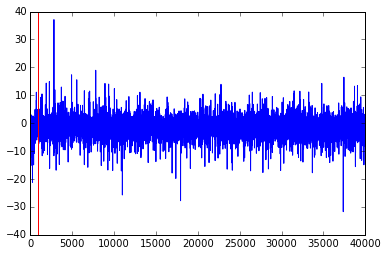

In [37]:
# detection_curve = detection_curve[1:]
# detection_curve -= min(detection_curve)
# detection_curve /= max(detection_curve)
plt.plot(detection_curve.ravel())
onsets = np.nonzero(actual_labels)
plt.plot([onsets[0],onsets[0]], [-40,40], 'r')
plt.show()

In [33]:
actual_labels[6280:6295]
np.nonzero(actual_labels)

(array([872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884,
        885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897,
        898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909]),)